https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os,sys
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
!ls

Yoga_2.ipynb archive.zip


**UNZIP FOLDER**

In [3]:
from zipfile import ZipFile
file = 'archive.zip'


with ZipFile (file, 'r') as zip:
  zip.extractall()
  print('Done')

Done


**ACCESS FOLDER**

In [4]:
os.listdir(os.listdir()[2])

['TEST', 'TRAIN']

In [5]:
path = os.getcwd()  + '/' + str(os.listdir()[2])

train_path = os.path.join(path,'TRAIN' )
test_path = os.path.join(path,'TEST')



**VIEW RANDOM IMAGES FROM TRAIN DATASET**

In [6]:
sample = []
for folder, sub_folder, files in os.walk(train_path):
  for j in files:
    sample.append(folder + '/' +  str (j))

In [7]:
index = np.random.randint(0, len(sample), 16)
index

array([ 597,  732,  333,  243,   37,  355,  822, 1040,  994,  885,  253,
        252,  110,  185,  181,  895])

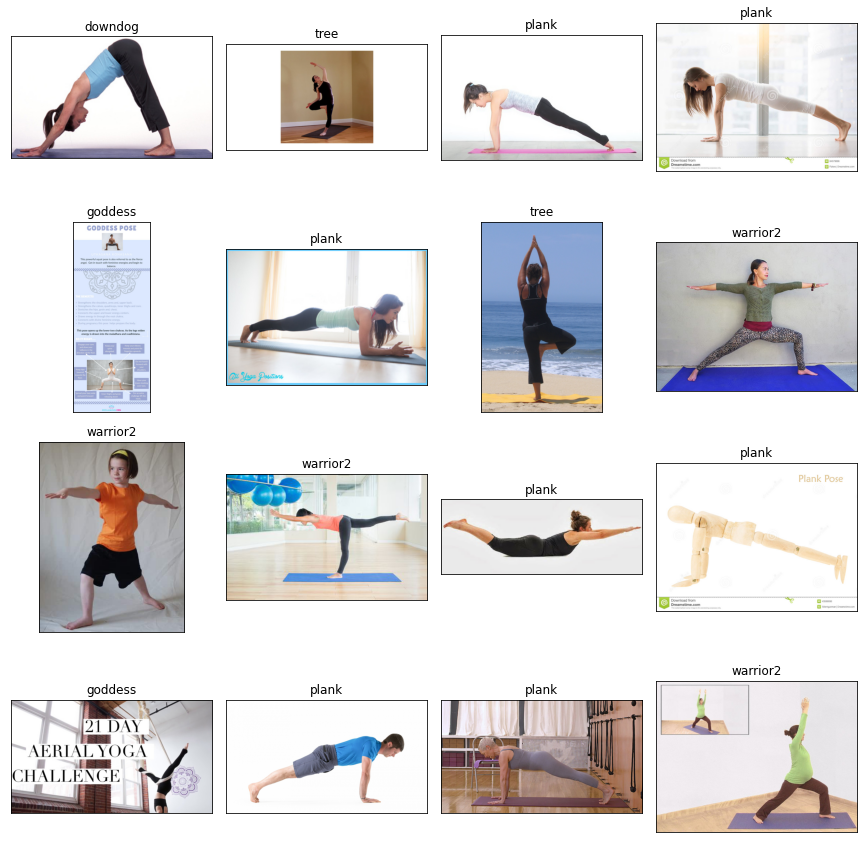

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(sample[index[i]]))
    ax.set_title(sample[index[i]].split('/')[4])
plt.tight_layout( pad=0.7, w_pad=1.0, h_pad=1.0)
plt.show()

**CREATE GENERATORS**

In [9]:
train_gen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range= 0,
                                   width_shift_range=0.05,
                                   height_shift_range = 0.05,
                                   shear_range = 0.05,
                                   zoom_range = 0.05,
                                   horizontal_flip = False,
                                  )


test_gen = ImageDataGenerator(rescale = 1./ 255.)

**VIEW EFFECT ON TRAIN IMAGE**

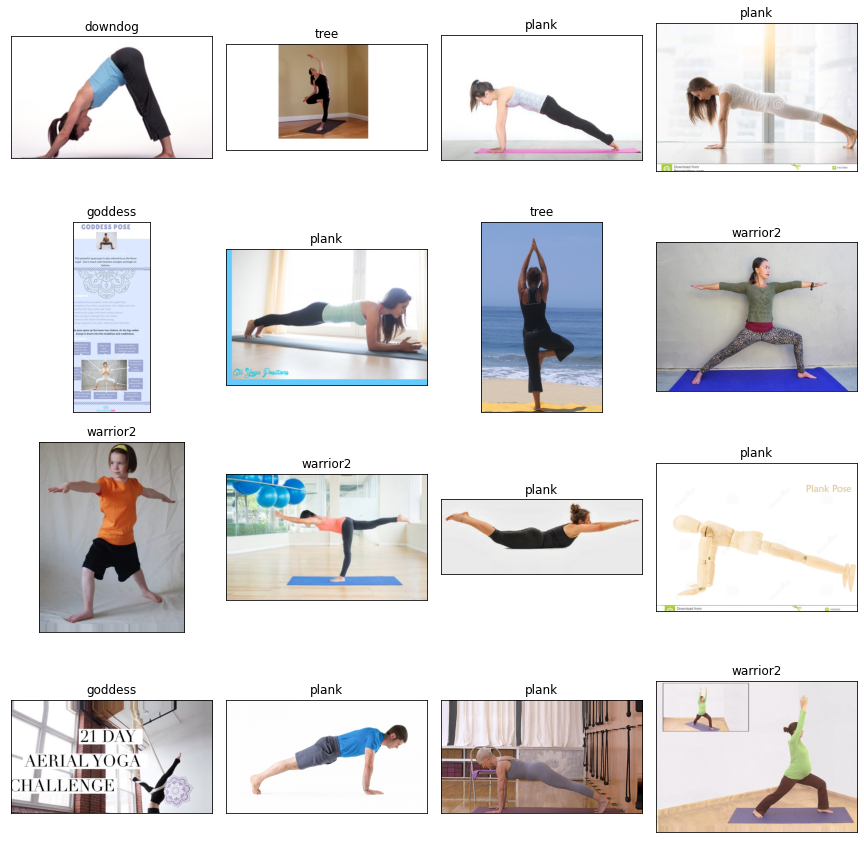

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
     
    img =  cv2.cvtColor(cv2.imread(sample[index[i]]), cv2.COLOR_BGR2RGB) #image gen only works with cv2
    img = train_gen.random_transform(img)
    ax.imshow((img))
    ax.set_title(sample[index[i]].split('/')[4])

plt.tight_layout( pad=0.7, w_pad=1.0, h_pad=1.0)
plt.show()

**INPUT GENERATOR**

In [11]:

image_size = [224,224]

#create image generators

traingen = train_gen.flow_from_directory(train_path,
                                  shuffle= True,
                                  target_size = image_size,
                                  batch_size= 16,
                                  class_mode = 'categorical')


testgen = test_gen.flow_from_directory(test_path,
                                  shuffle= True,
                                  target_size = image_size,
                                  batch_size= 16,
                                  class_mode = 'categorical' )

Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


**CREATE MODEL**

In [12]:
model = Sequential()

#convolutional layer


model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(224, 224,3), activation='relu', padding = 'same')) 
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding = 'same')) 
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding = 'same')) 
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding = 'same')) 
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding = 'same')) 
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding = 'same')) 
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))



#flatten from 2d to 1d, h,w to 1d
model.add(Flatten())


#dense layer





model.add(Dense(200, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(100, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(50, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(25, activation = 'relu'))
model.add(Dropout(0.2))


model.add(Dense(5, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)


In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

results = model.fit(traingen,steps_per_epoch= 1081 // 16 ,validation_data=testgen, validation_steps=  470 // 16,verbose=1,epochs=100,callbacks=[early_stop] )

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


67/67 [==============================] - ETA: 0s - loss: 1.6027 - accuracy: 0.2498

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


67/67 [==============================] - 40s 547ms/step - loss: 1.6027 - accuracy: 0.2498 - val_loss: 1.5998 - val_accuracy: 0.2457
Epoch 2/100
67/67 [==============================] - 46s 689ms/step - loss: 1.5992 - accuracy: 0.2385 - val_loss: 1.5955 - val_accuracy: 0.2457
Epoch 3/100
67/67 [==============================] - 36s 539ms/step - loss: 1.5949 - accuracy: 0.2404 - val_loss: 1.5636 - val_accuracy: 0.2478
Epoch 4/100
67/67 [==============================] - 37s 549ms/step - loss: 1.5545 - accuracy: 0.2610 - val_loss: 1.4810 - val_accuracy: 0.3966
Epoch 5/100
67/67 [==============================] - 36s 533ms/step - loss: 1.5007 - accuracy: 0.3502 - val_loss: 1.3433 - val_accuracy: 0.4353
Epoch 6/100
67/67 [==============================] - 36s 540ms/step - loss: 1.3569 - accuracy: 0.4657 - val_loss: 0.9245 - val_accuracy: 0.6185
Epoch 7/100
67/67 [==============================] - 36s 536ms/step - loss: 1.1843 - accuracy: 0.5352 - val_loss: 0.7434 - val_accuracy: 0.7241
Epoc

In [16]:
model.evaluate(testgen)

30/30 [==============================] - 11s 382ms/step - loss: 0.2743 - accuracy: 0.9106


[0.2743101418018341, 0.9106382727622986]

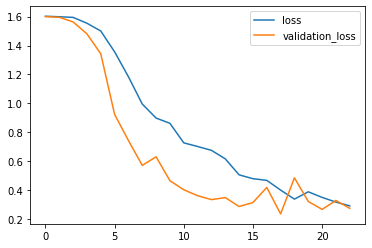

In [19]:
plt.plot(results.history['loss'], label = 'loss')
plt.plot(results.history['val_loss'], label = 'validation_loss')
plt.legend()